## 0. Load Libraries

In [183]:
# Basic libraries
import numpy as np
import pandas as pd
import re
from collections import Counter

# Data preprocessing and feature engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

# Data balancing
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# NLP libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Machine learning libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.regularizers import l1_l2

# Model evaluation libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Model serialization
import pickle

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Text Preprocessing

## 1.0: data info

In [184]:
df = pd.read_csv('data/mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [185]:
df.type.value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


## 1.1 Data Preprocessing

## 1.1.1: Text Cleaning and Tokenization:

1. **Remove Special Characters and URLs**: Any URLs and special characters are removed from the text to avoid irrelevant information that could interfere with model predictions.

2. **Convert to Lowercase**: All text is converted to lowercase to maintain uniformity, making it easier to analyze and compare words regardless of their original capitalization.

3. **Remove Stopwords**: Common filler words, such as "a," "an," and "the," which add little value to the meaning of the text, are removed. This reduces noise and focuses the data on more meaningful content.

4. **Tokenization**: The text is broken down into individual words (tokens), allowing us to process each word independently for further analysis.

5. **Lemmatization**: Each word is reduced to its base form. This helps group words with similar meanings (e.g., "running" and "run") and simplifies the text data.

6. **Handle Missing Data**: Any missing entries in the `posts` column are replaced with an empty string to ensure consistency.

In [197]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function to clean and preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+|bit\.ly/\S+', '', text, flags=re.MULTILINE)

    # Remove special characters (retain only letters and numbers)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to a single string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply preprocessing to the 'posts' column
df['cleaned_posts'] = df['posts'].apply(lambda x: preprocess_text(str(x)))

# Handle missing data in 'cleaned_posts'
df['cleaned_posts'].fillna('', inplace=True)

# Check the processed data
print(df[['type', 'cleaned_posts']].head())

   type                                      cleaned_posts
0  INFJ  intj moment sportscenter top ten play prankswh...
1  ENTP  im finding lack post alarmingsex boring positi...
2  INTP  good one course say know thats blessing cursed...
3  INTJ  dear intp enjoyed conversation day esoteric ga...
4  ENTJ  youre firedthats another silly misconception a...


/var/folders/yd/0rx8hpn96fd0480f9ndhwn_00000gn/T/ipykernel_9929/2208585870.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cleaned_posts'].fillna('', inplace=True)


## 1.1.2: Label Encoding:
- Encodes MBTI types into integers, which is suitable for machine learning algorithms that require numerical labels.
- Saves the mapping for later interpretation.

In [191]:
# Encode MBTI types into integer labels
label_encoder = LabelEncoder()
df['encoded_type'] = label_encoder.fit_transform(df['type'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'ENFJ': 0,
 'ENFP': 1,
 'ENTJ': 2,
 'ENTP': 3,
 'ESFJ': 4,
 'ESFP': 5,
 'ESTJ': 6,
 'ESTP': 7,
 'INFJ': 8,
 'INFP': 9,
 'INTJ': 10,
 'INTP': 11,
 'ISFJ': 12,
 'ISFP': 13,
 'ISTJ': 14,
 'ISTP': 15}

## 1.2: Data Splitting

### 1.2.1: Development-Test Split (80/20):
- Splits the full dataset into a development set (80%) and a test set (20%) using stratified sampling based on MBTI types.
- Maintains class distribution in both sets, as recommended for imbalanced datasets ￼.

In [194]:
# Separate features and target
X = df['cleaned_posts']
y = df['encoded_type']

# Split into Development and Test Sets (80/20 split)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 1.2.2: Training-Validation Split (75/25 of Development Set):
- Further splits the development set into a training set (75%) and a validation set (25%) using stratified sampling.
- This partition allows for hyperparameter tuning on the validation set without affecting the test set, as per class guidelines.

In [195]:
# Split Development Set into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, stratify=y_dev, random_state=42)

### 1.2.3: Class Distribution Check:
- Prints class distribution for each split to confirm successful stratification, ensuring that each subset reflects the original data’s class proportions

In [196]:
print("Data split sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Data split sizes:
Training set: 5205 samples
Validation set: 1735 samples
Test set: 1735 samples


In [126]:
# Display the shape of the original splitted data
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (5205,)
Validation set shape: (1735,)
Test set shape: (1735,)


## 1.3: Feature Engineering

### 1.3.1: TF-IDF Vectorization:
- Convert cleaned text into numerical features, using TF-IDF to capture the importance of words relative to each personality type across the dataset. Limit to the top 5000 features for efficiency.

In [151]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit the vectorizer on the training data and transform the training data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

- TFIDF shape

In [152]:
print(f"TF-IDF Training set shape: {X_train_tfidf.shape}")
print(f"TF-IDF Validation set shape: {X_val_tfidf.shape}")
print(f"TF-IDF Test set shape: {X_test_tfidf.shape}")

TF-IDF Training set shape: (5205, 5000)
TF-IDF Validation set shape: (1735, 5000)
TF-IDF Test set shape: (1735, 5000)


### 1.3.2: Elastic Net feature selection and regularization
- Elastic Net to identify and retain the most relevant words for distinguishing between personality types, reducing noise and focusing on important features.

In [160]:
# Initialize Elastic Net with cross-validation
elastic_net = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, random_state=42)

# Use Elastic Net for feature selection on TF-IDF transformed training data
select_model = SelectFromModel(estimator=elastic_net, threshold='mean')

# Fit on training data to determine the selected features
select_model.fit(X_train_tfidf, y_train)

# Transform training, validation, and test data to keep only selected features
X_train_selected = select_model.transform(X_train_tfidf)
X_val_selected = select_model.transform(X_val_tfidf)
X_test_selected = select_model.transform(X_test_tfidf)

- Elastic Net shape

In [161]:
print("Reduced Training set shape:", X_train_selected.shape)
print("Reduced Validation set shape:", X_val_selected.shape)
print("Reduced Test set shape:", X_test_selected.shape)

Reduced Training set shape: (5205, 445)
Reduced Validation set shape: (1735, 445)
Reduced Test set shape: (1735, 445)


### After the TF-IDF vectorization, the current dataset is both sparse and imbalanced

## 1.4: Class Balancing techniques

### 1.4.1: Handling data sparsity with feature selection

- Variance-Based Filtering: Remove features with minimal variance across samples, further refining the feature set.

In [ ]:
# Set a variance threshold to filter out low-variance features in Elastic-Net matrix
variance_filter = VarianceThreshold(threshold=0.0001)

# Fit the variance threshold on the balanced training set and transform the training, validation, and test sets
X_train_var = variance_filter.fit_transform(X_train_selected)
X_val_var = variance_filter.transform(X_val_selected)
X_test_var = variance_filter.transform(X_test_selected)

In [165]:
print(f"Variance-Based Training set shape: {X_train_var.shape}")
print(f"Variance-Based Validation set shape: {X_val_var.shape}")
print(f"Variance-Based Test set shape: {X_test_var.shape}")

Variance-Based Training set shape: (5205, 422)
Variance-Based Validation set shape: (1735, 422)
Variance-Based Test set shape: (1735, 422)


### 1.4.2: Handling data sparsity with feature transformation

- PCA: Apply PCA to condense features while retaining 95% of the data’s variance, creating a compact and information-rich feature space.

In [166]:
# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)

# Fit PCA on the balanced training set and transform the training, validation, and test sets
X_train_pca = pca.fit_transform(X_train_var.toarray())
X_val_pca = pca.transform(X_val_var.toarray())
X_test_pca = pca.transform(X_test_var.toarray())

In [167]:
print(f"PCA Training set shape: {X_train_pca.shape}")
print(f"PCA Validation set shape: {X_val_pca.shape}")
print(f"PCA Test set shape: {X_test_pca.shape}")

PCA Training set shape: (5205, 341)
PCA Validation set shape: (1735, 341)
PCA Test set shape: (1735, 341)


### 1.4.3: Handling data imbalance by SMOTE

- Use SMOTE to balance the training dataset across personality types by generating synthetic samples, ensuring that models don’t become biased towards majority classes.

In [169]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

In [170]:
print("Class distribution in the balanced training set:")
print(pd.Series(y_train_smote).value_counts())

Class distribution in the balanced training set:
encoded_type
9     1099
2     1099
8     1099
11    1099
1     1099
10    1099
14    1099
13    1099
3     1099
15    1099
6     1099
12    1099
0     1099
7     1099
4     1099
5     1099
Name: count, dtype: int64


# 2: Model training

In [178]:
# Dictionary to hold models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}")
    print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred)}")

Logistic Regression - Accuracy: 0.6138328530259366
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.44      0.63      0.52        38
           1       0.67      0.61      0.64       135
           2       0.38      0.57      0.46        46
           3       0.61      0.58      0.60       137
           4       0.38      0.56      0.45         9
           5       0.00      0.00      0.00        10
           6       0.04      0.12      0.06         8
           7       0.09      0.22      0.13        18
           8       0.79      0.59      0.68       294
           9       0.79      0.63      0.70       366
          10       0.65      0.59      0.62       218
          11       0.73      0.71      0.72       261
          12       0.56      0.73      0.63        33
          13       0.35      0.56      0.43        54
          14       0.40      0.59      0.48        41
          15       0.50      0.70    

/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

XGBoost - Accuracy: 0.6219020172910663
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.46      0.55      0.50        38
           1       0.62      0.56      0.59       135
           2       0.44      0.41      0.43        46
           3       0.57      0.60      0.58       137
           4       0.43      0.33      0.38         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         8
           7       0.20      0.06      0.09        18
           8       0.66      0.68      0.67       294
           9       0.68      0.72      0.70       366
          10       0.58      0.59      0.59       218
          11       0.68      0.69      0.69       261
          12       0.50      0.52      0.51        33
          13       0.51      0.41      0.45        54
          14       0.61      0.49      0.54        41
          15       0.59      0.69      0.63        67

    ac

# 3. Tuning Parameter

## 3.1: Use RandomsearchCV for hyper-parameter tuning
- 80% for model training.
- 20% for model testing.

In [13]:
# Define parameter
param_dist = [
    {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'penalty': ['l2'], 'C': loguniform(1e-4, 1e+2)},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': loguniform(1e-4, 1e+2)},
    {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': loguniform(1e-4, 1e+2), 'l1_ratio': np.linspace(0.1, 0.9, 10)},
    {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'penalty': [None]} 
]

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Setup RandomizedSearchCV with verbose output
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, scoring='accuracy', n_jobs=-1, cv=3, random_state=42, verbose=3)

# Fit the RandomizedSearchCV to find the best parameters
random_search.fit(X_train_smote, y_train_smote)

# Print the best parameters found
print("Best Parameters found: ", random_search.best_params_)

# Use the best estimator to make predictions on the test set
y_pred_test = random_search.best_estimator_.predict(X_test_tfidf)

# Calculate and print accuracy, precision, and recall for the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='macro')
recall_test = recall_score(y_test, y_pred_test, average='macro')

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END C=0.00039796923010559904, l1_ratio=0.7222222222222222, penalty=elasticnet, solver=saga;, score=0.062 total time=   2.4s
[CV 1/3] END C=0.00039796923010559904, l1_ratio=0.7222222222222222, penalty=elasticnet, solver=saga;, score=0.063 total time=   7.9s
[CV 3/3] END C=0.00039796923010559904, l1_ratio=0.7222222222222222, penalty=elasticnet, solver=saga;, score=0.063 total time=  12.5s
[CV 1/3] END C=0.4042872735027334, penalty=l2, solver=saga;, score=0.859 total time=  25.3s
[CV 2/3] END C=0.4042872735027334, penalty=l2, solver=saga;, score=0.911 total time=  18.8s
[CV 1/3] END C=0.00013289448722869195, l1_ratio=0.18888888888888888, penalty=elasticnet, solver=saga;, score=0.062 total time=   3.1s
[CV 1/3] END C=0.3811544088653064, penalty=l2, solver=lbfgs;, score=0.857 total time=  37.3s
[CV 3/3] END C=0.00013289448722869195, l1_ratio=0.18888888888888888, penalty=elasticnet, solver=saga;, score=0.062 total time=   

/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3] END C=0.006690421166498805, penalty=l2, solver=lbfgs;, score=0.816 total time=   3.8s
[CV 3/3] END ....penalty=None, solver=newton-cg;, score=0.970 total time= 1.5min
[CV 3/3] END C=0.006690421166498805, penalty=l2, solver=lbfgs;, score=0.775 total time=   3.7s
[CV 1/3] END C=0.039054412752107935, penalty=l2, solver=newton-cg;, score=0.775 total time=   8.0s
[CV 2/3] END C=0.039054412752107935, penalty=l2, solver=newton-cg;, score=0.851 total time=   6.9s
[CV 3/3] END C=0.039054412752107935, penalty=l2, solver=newton-cg;, score=0.825 total time=   8.4s
[CV 1/3] END C=6.015308718396457, l1_ratio=0.7222222222222222, penalty=elasticnet, solver=saga;, score=0.878 total time= 6.1min
[CV 2/3] END C=6.015308718396457, l1_ratio=0.7222222222222222, penalty=elasticnet, solver=saga;, score=0.924 total time= 6.6min
[CV 3/3] END C=6.015308718396457, l1_ratio=0.7222222222222222, penalty=elasticnet, solver=saga;, score=0.959 total time= 6.8min
[CV 3/3] END .........penalty=None, solver=saga;

/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3.2: Use best tunned parameter to test whole labels
- full dataset for y-labels
- save the best parameter for models

In [14]:
# use TF-IDF and Smote for retraining process
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X) 
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, y)

# Best parameters as found from tuning
best_params = {'penalty': None, 'solver': 'saga'} 

# Initialize and train the Logistic Regression model using the best parameters on the entire dataset
model = LogisticRegression(**best_params, max_iter=1000)
model.fit(X_smote, y_smote)

LogisticRegression(max_iter=1000, penalty=None, solver='saga')

## 3.3: Save to the output path

In [15]:
# Save this best model to a pickle file
with open('output/best_model_logistic_regression.pkl', 'wb') as file:
    pickle.dump(model, file)

print("The best model was saved to 'output/best_model_logistic_regression.pkl'")

The best model was saved to 'output/best_model_logistic_regression.pkl'


# 4. Extract Feature Importance

## 4.1: feature balancing

In [16]:
# Balancing data by SMOTE
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, y)

In [17]:
# Extract the models with best parameter
filename = 'output/best_model_logistic_regression.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

## 4.2: label manipulation

In [18]:
# set up mapping between label indices and label names
coef = model.coef_

# mapping labels to names
map_label = {}
for key, val in label_mapping.items():
  map_label[val] = key

## 4.3 Visualization of feature importance

[nltk_data] Downloading package words to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


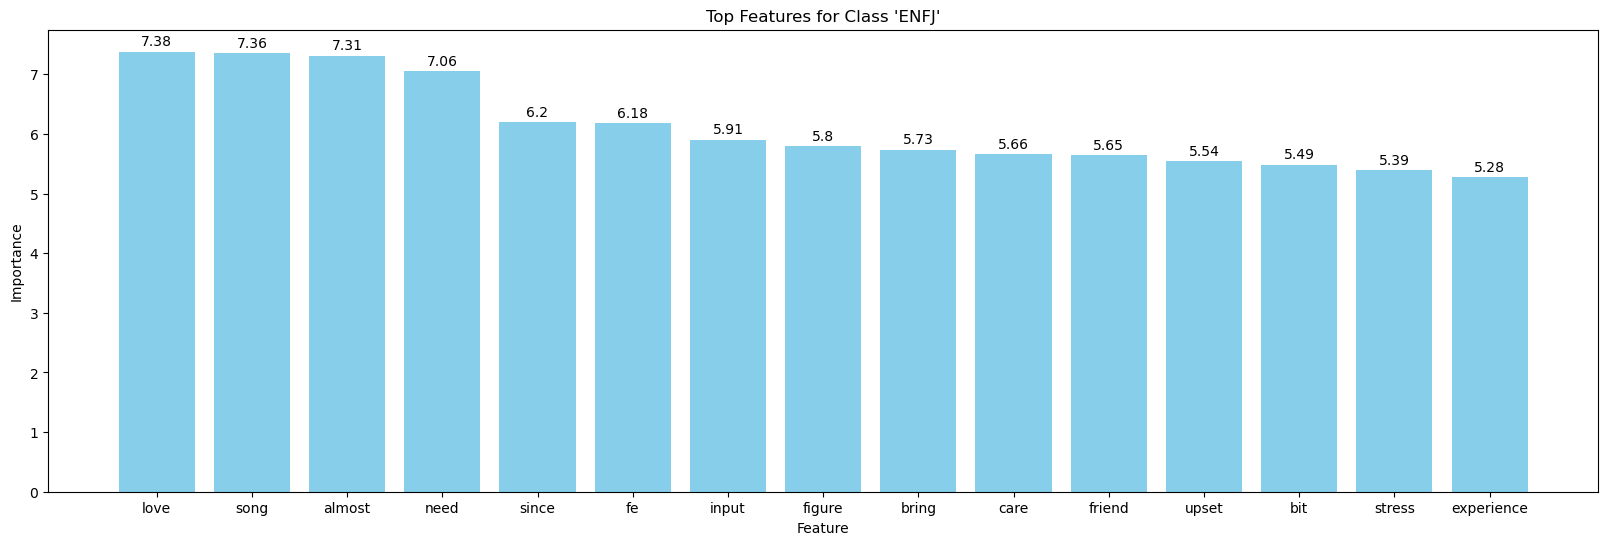

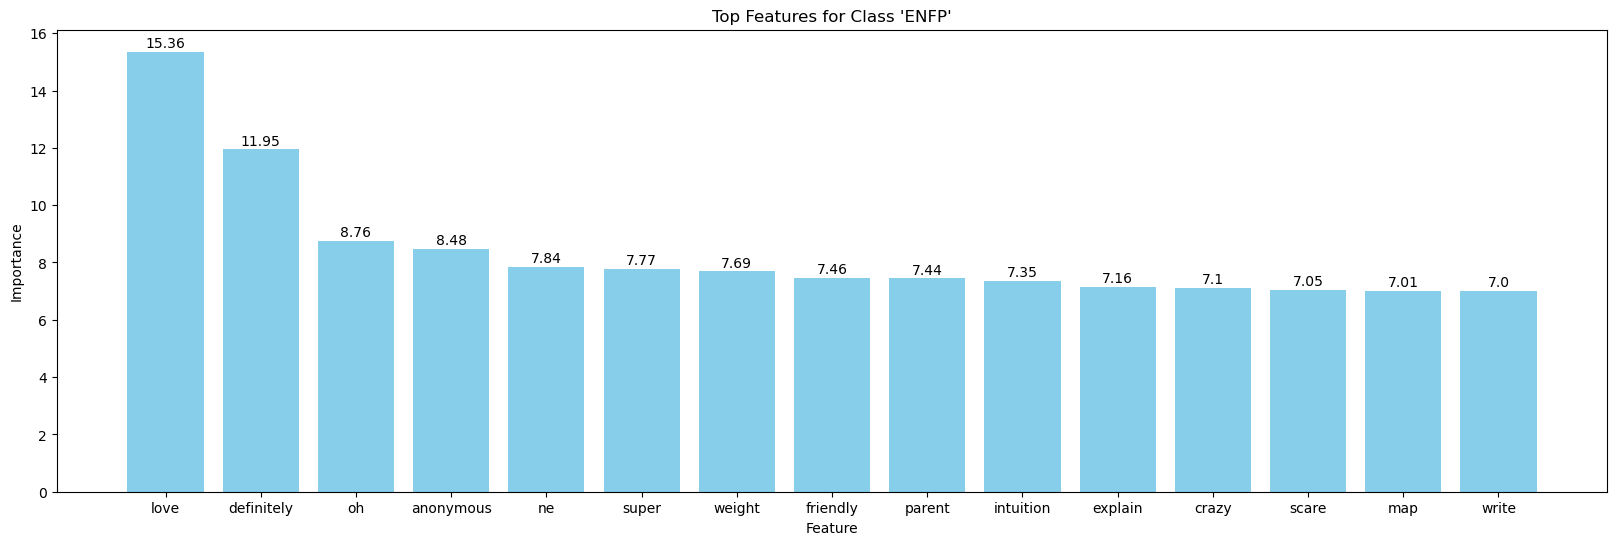

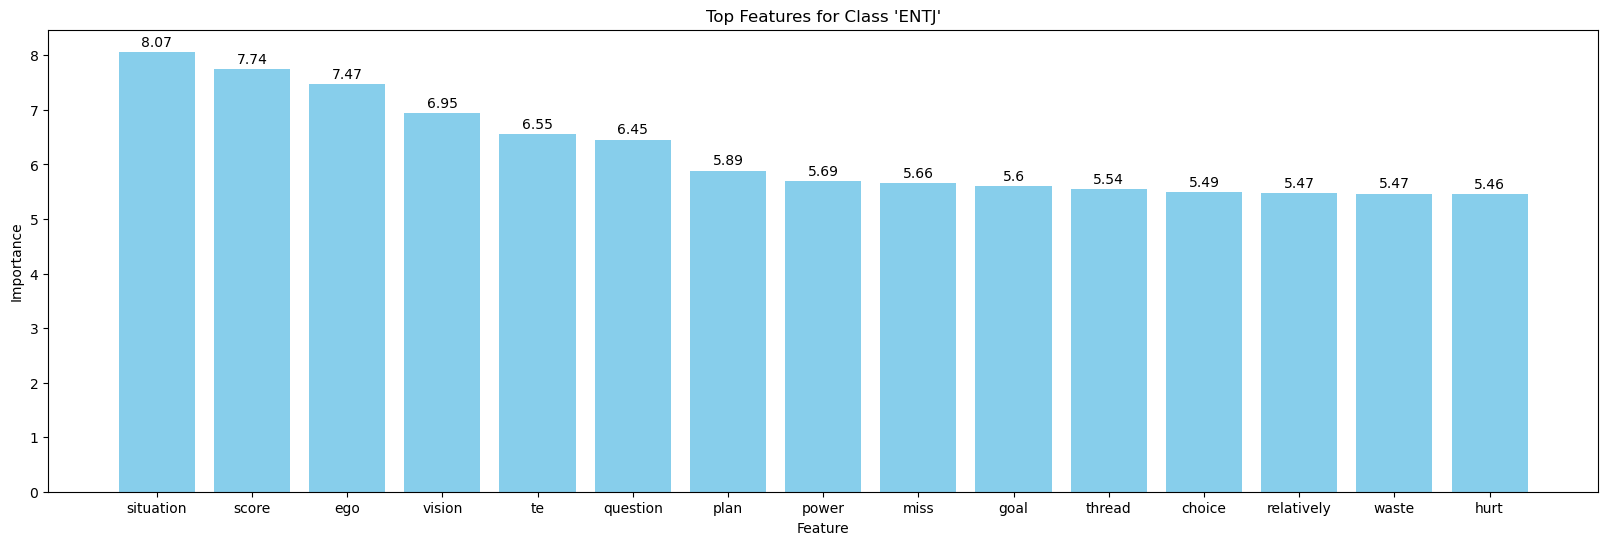

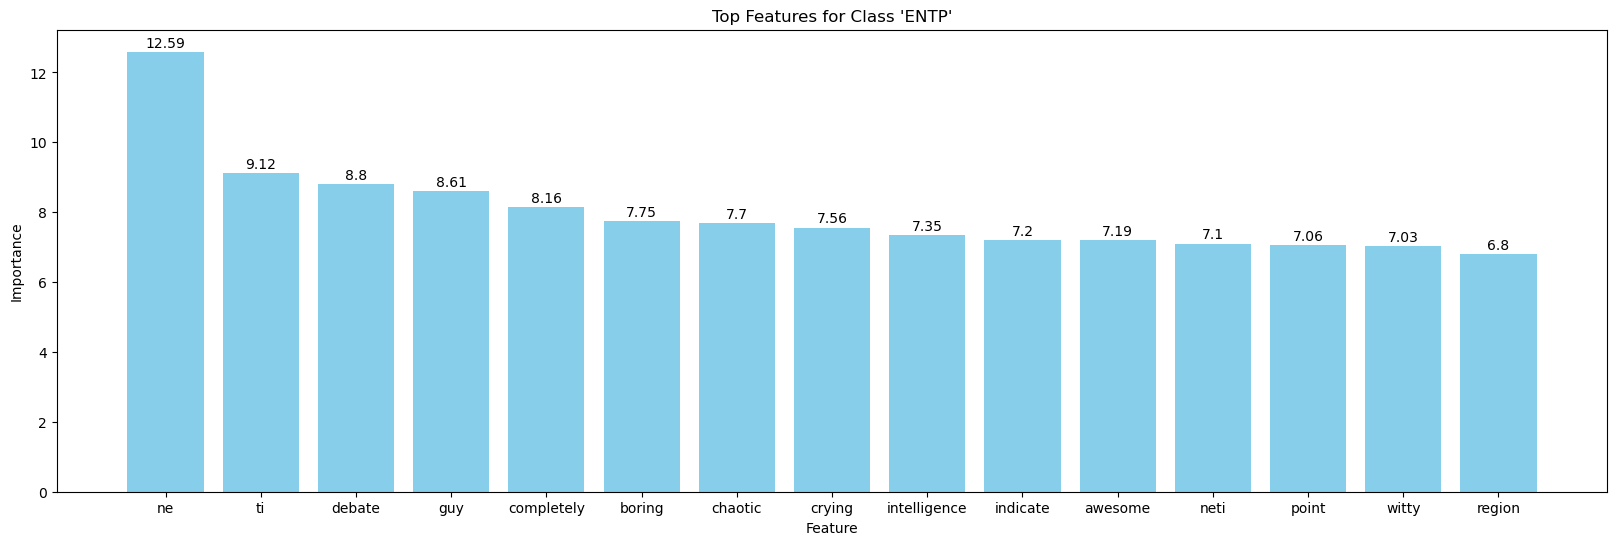

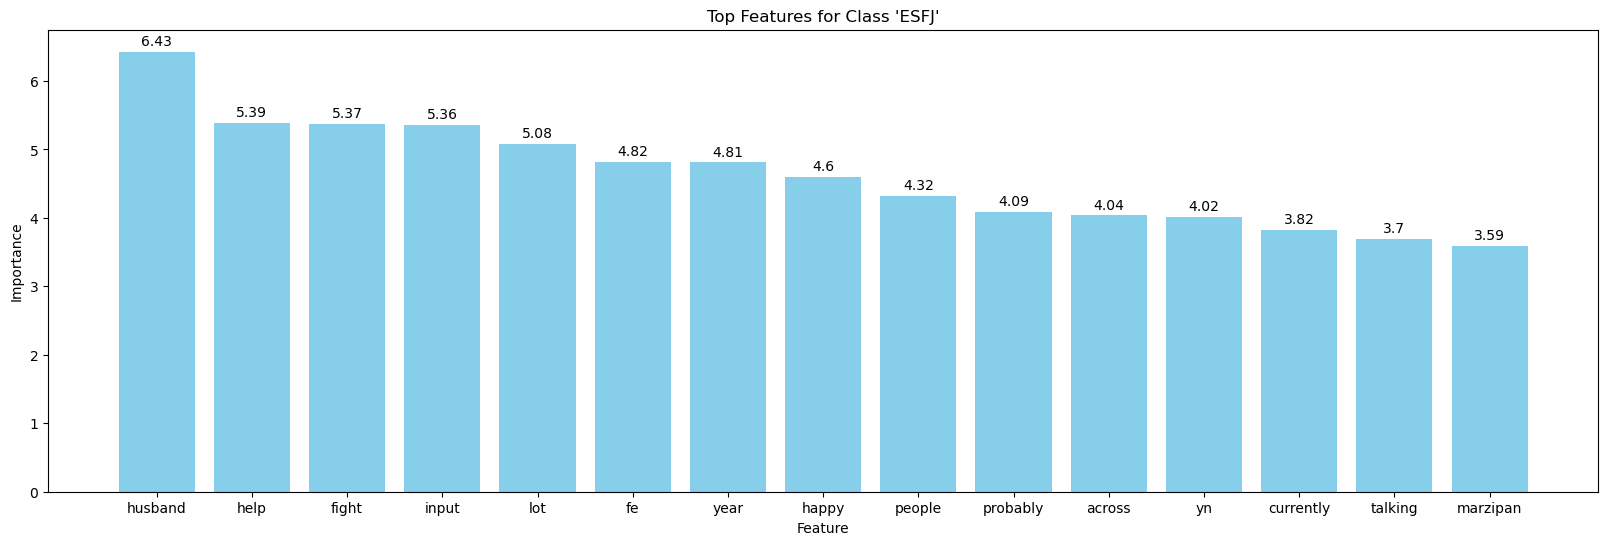

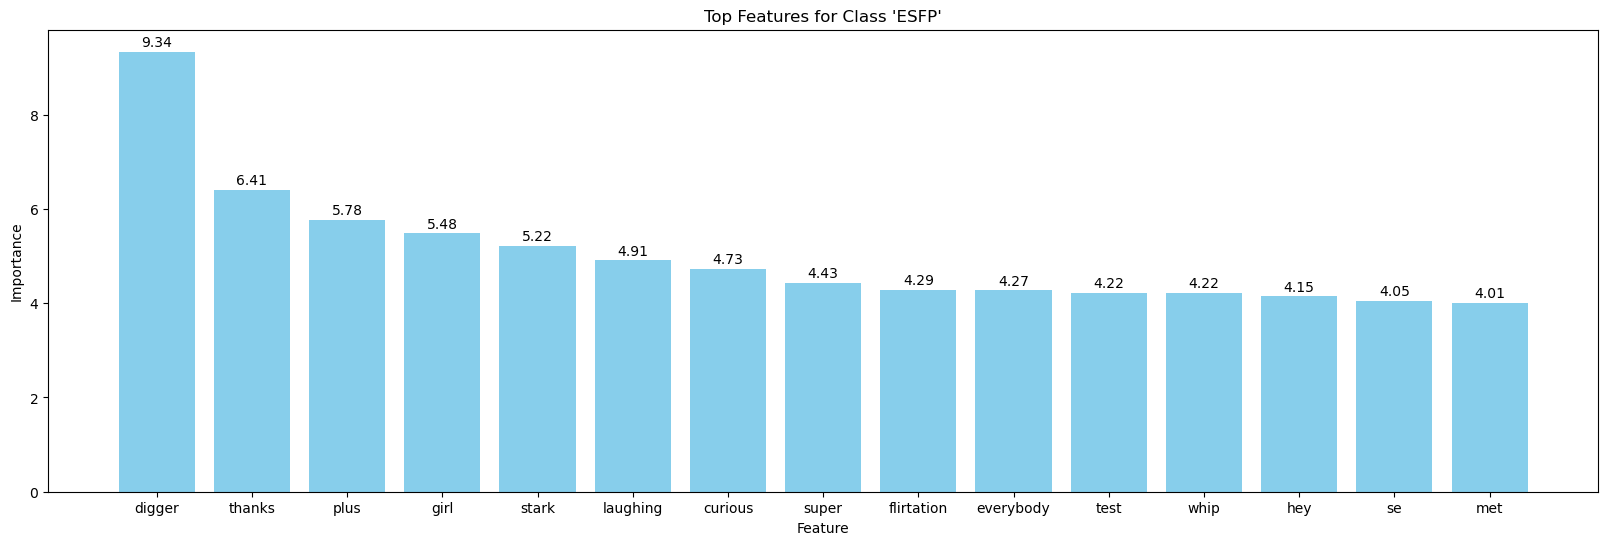

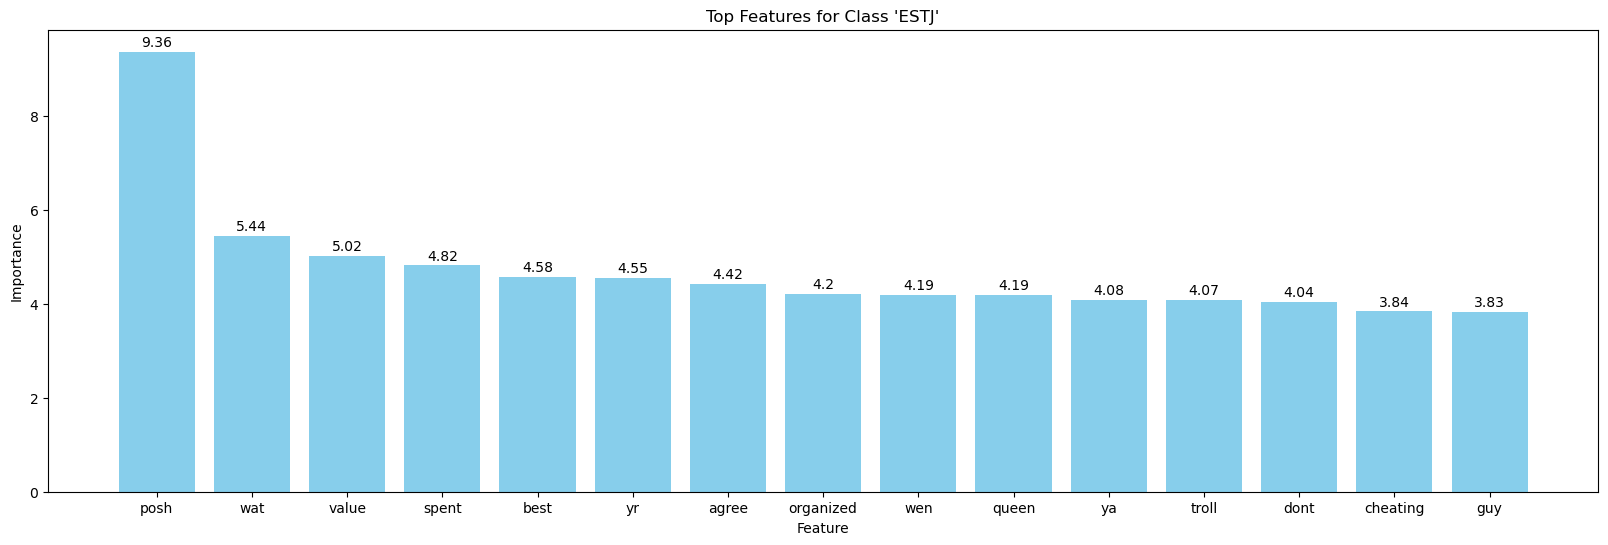

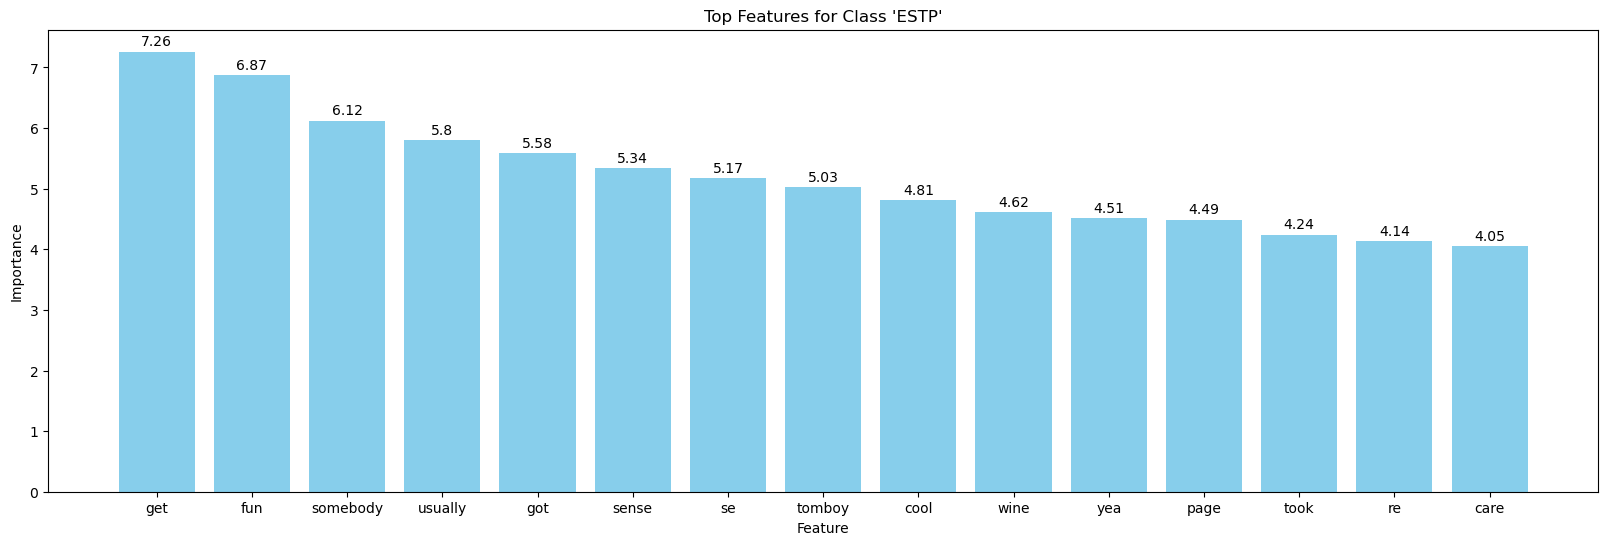

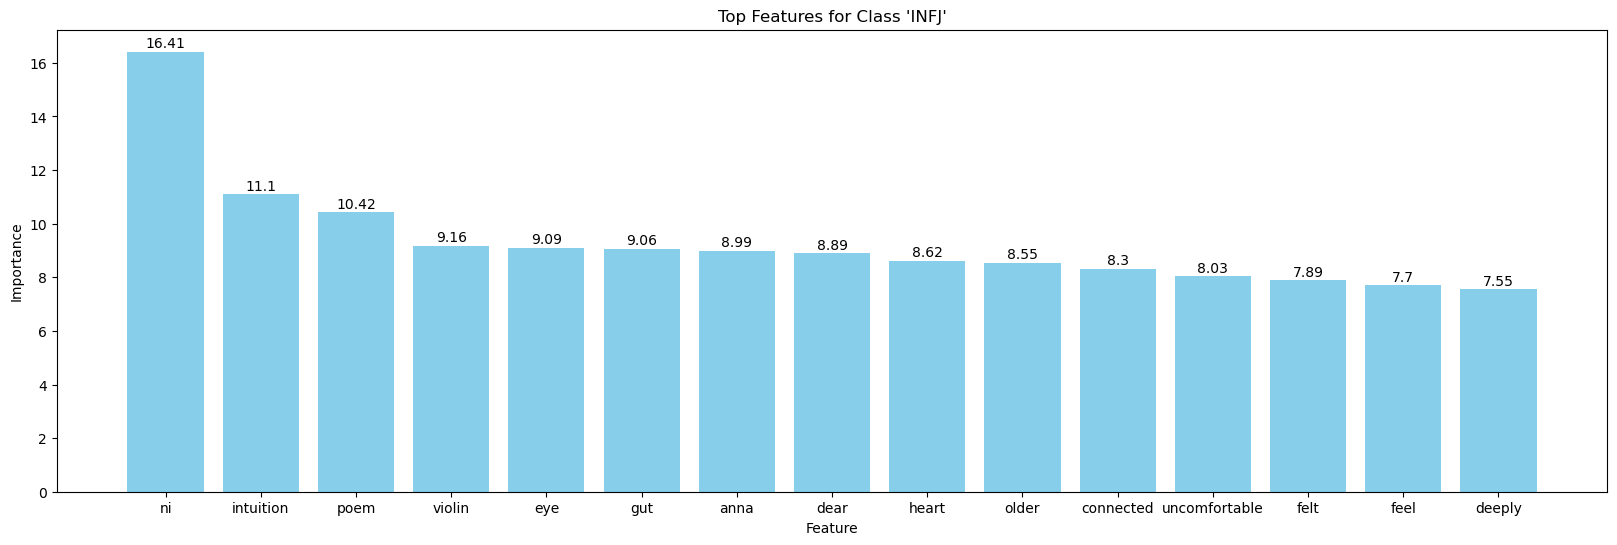

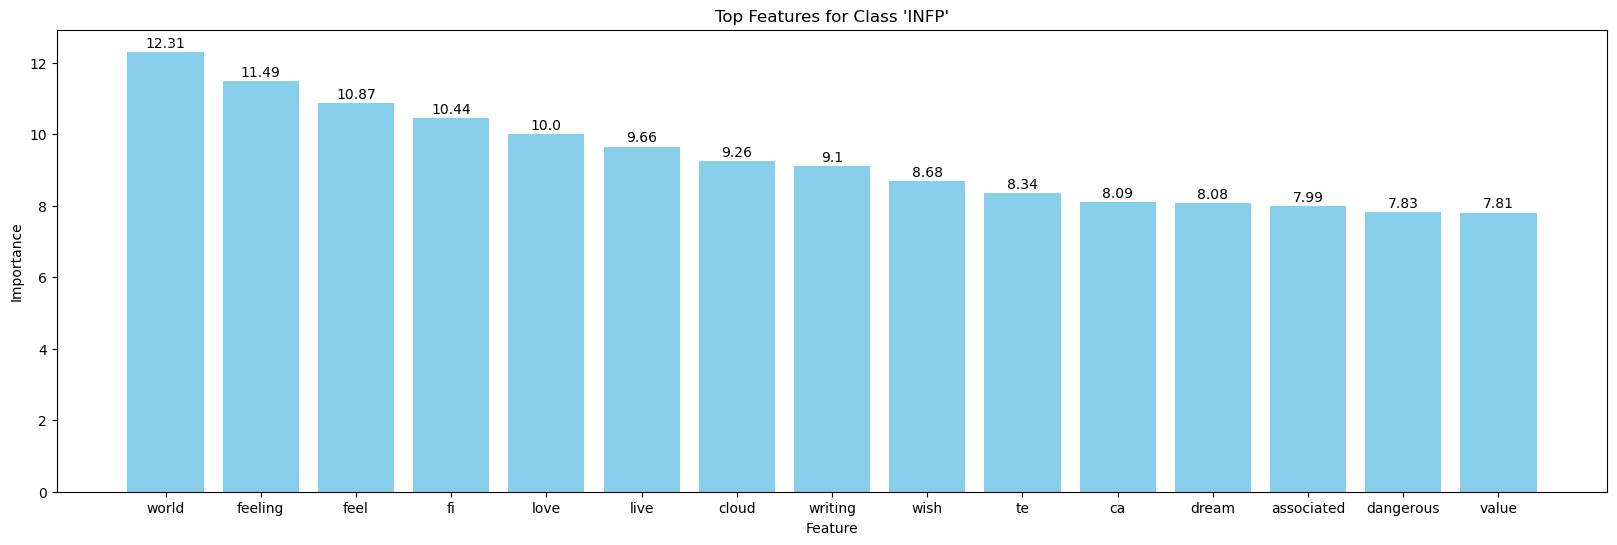

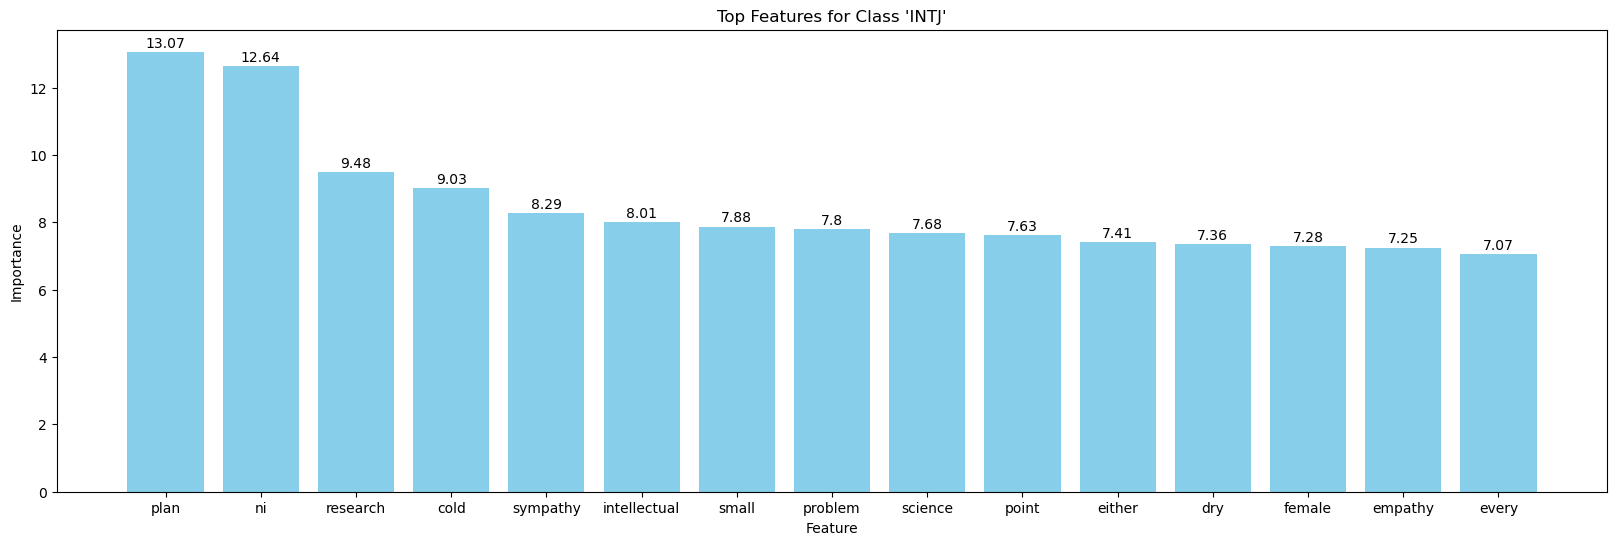

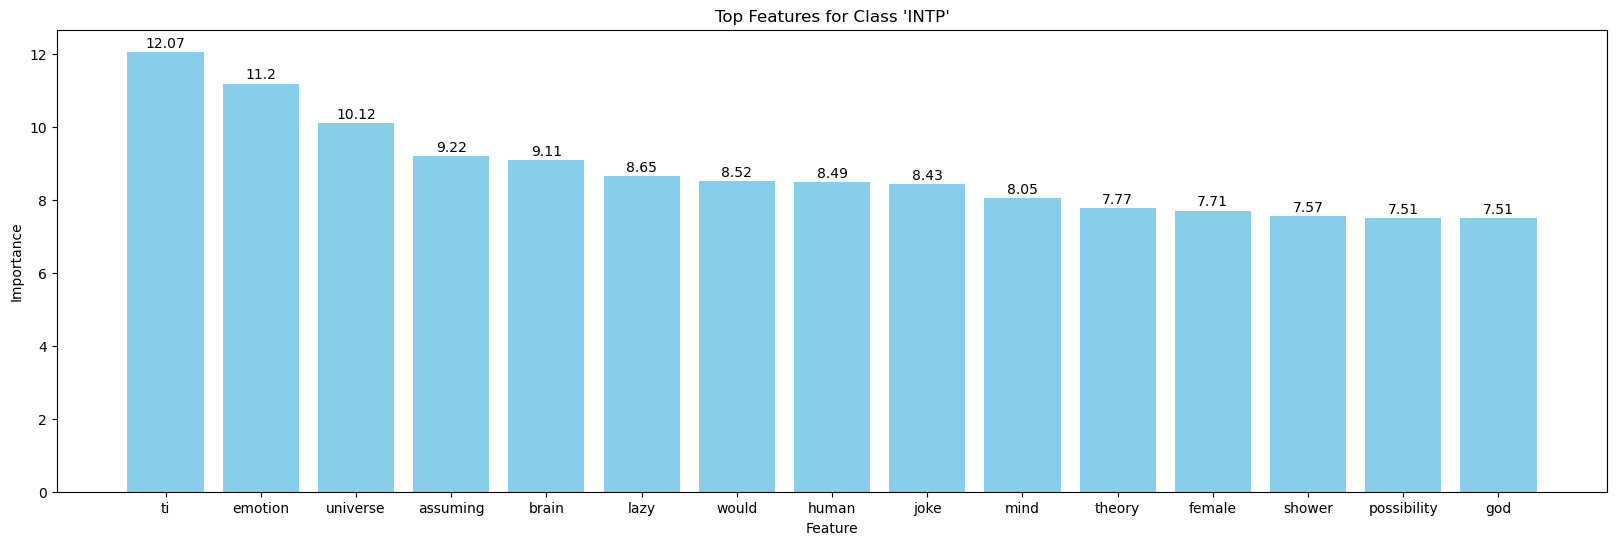

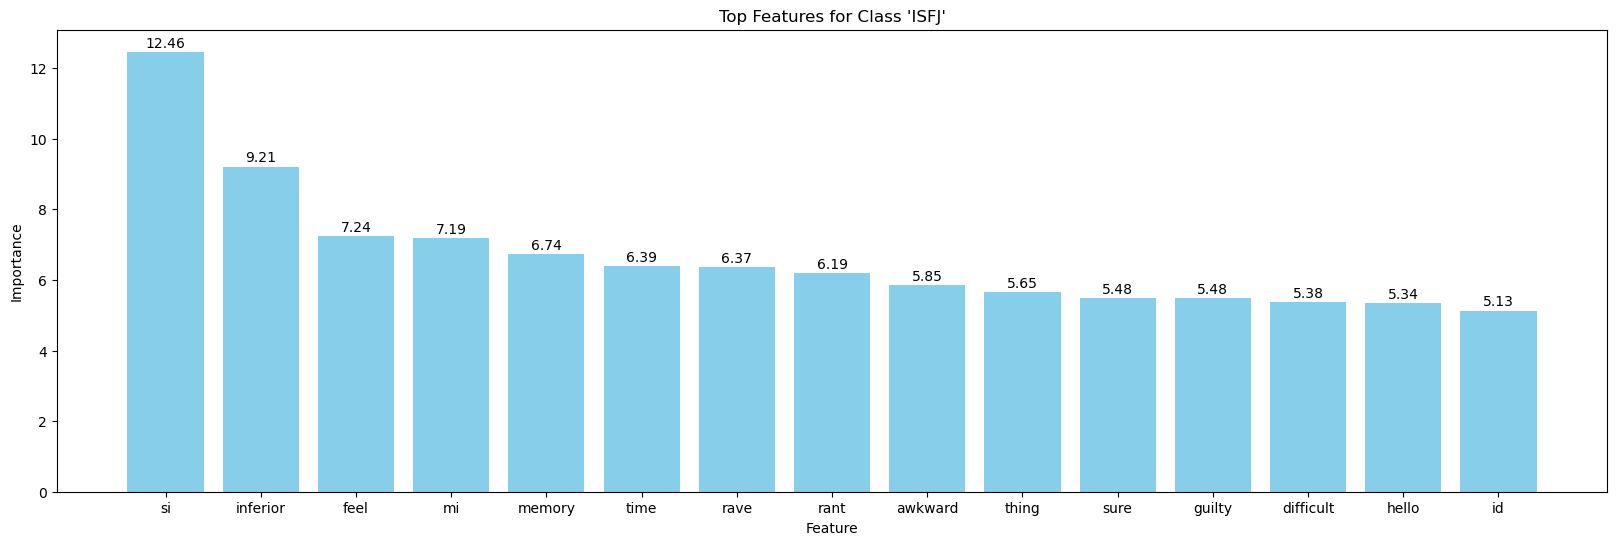

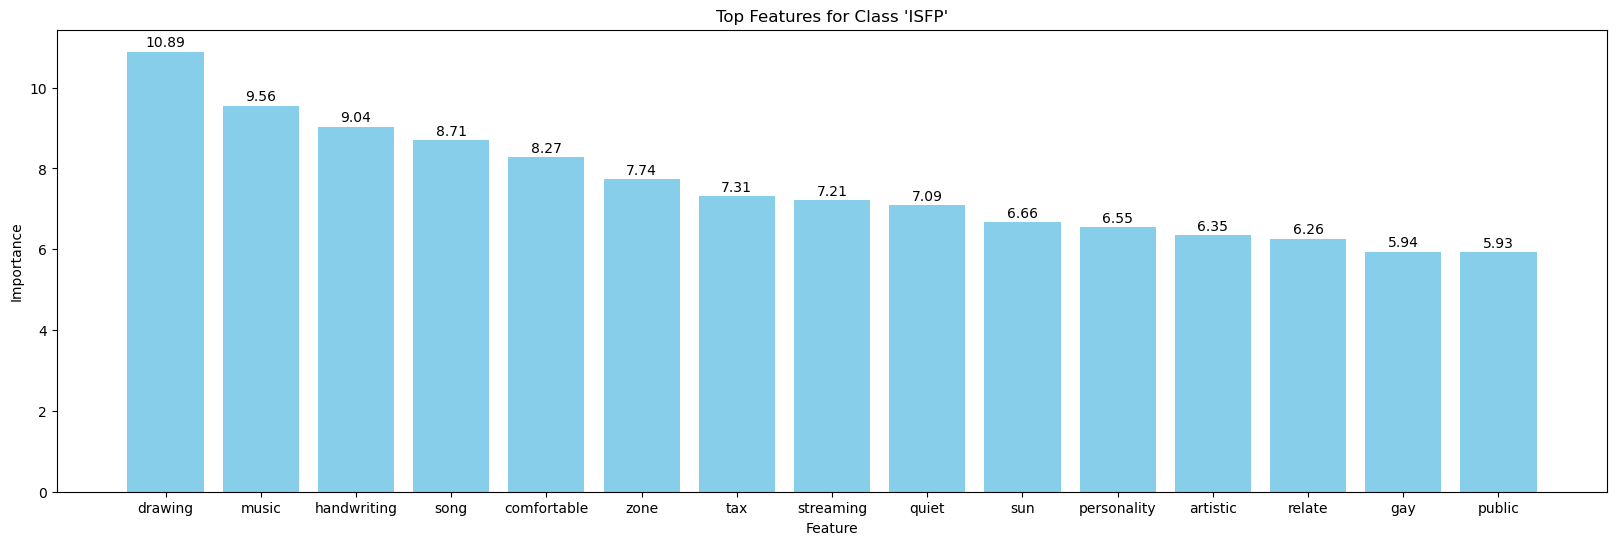

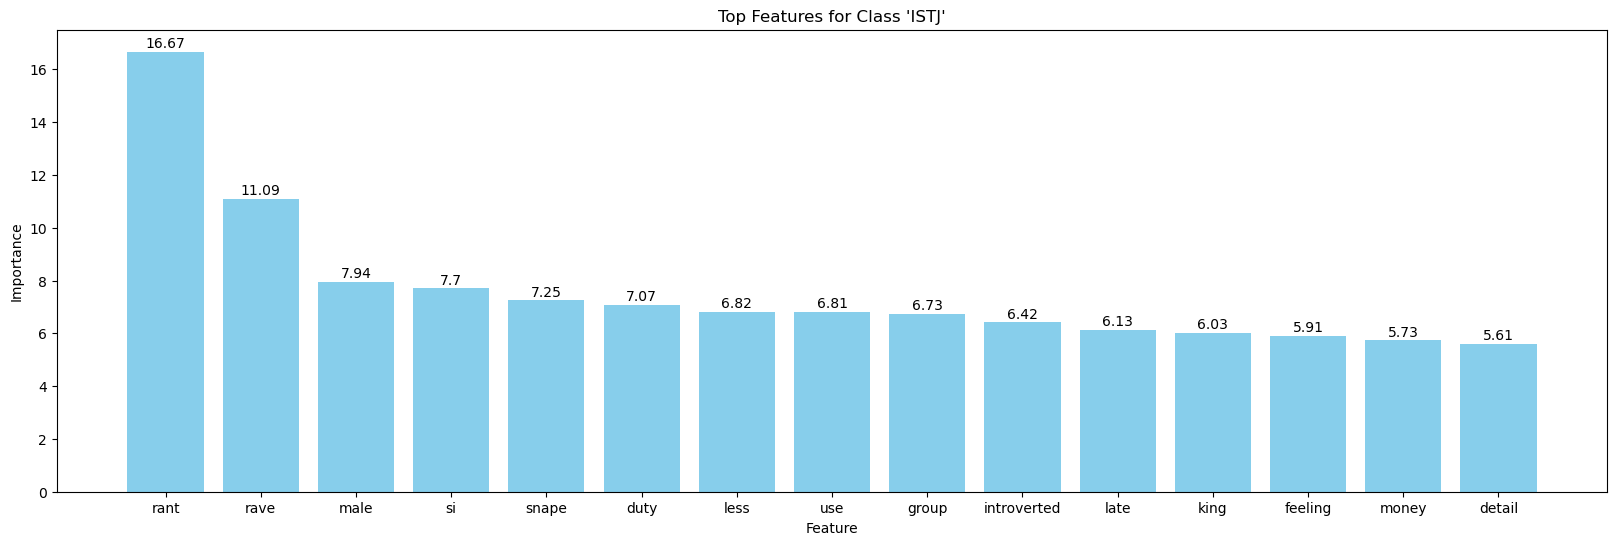

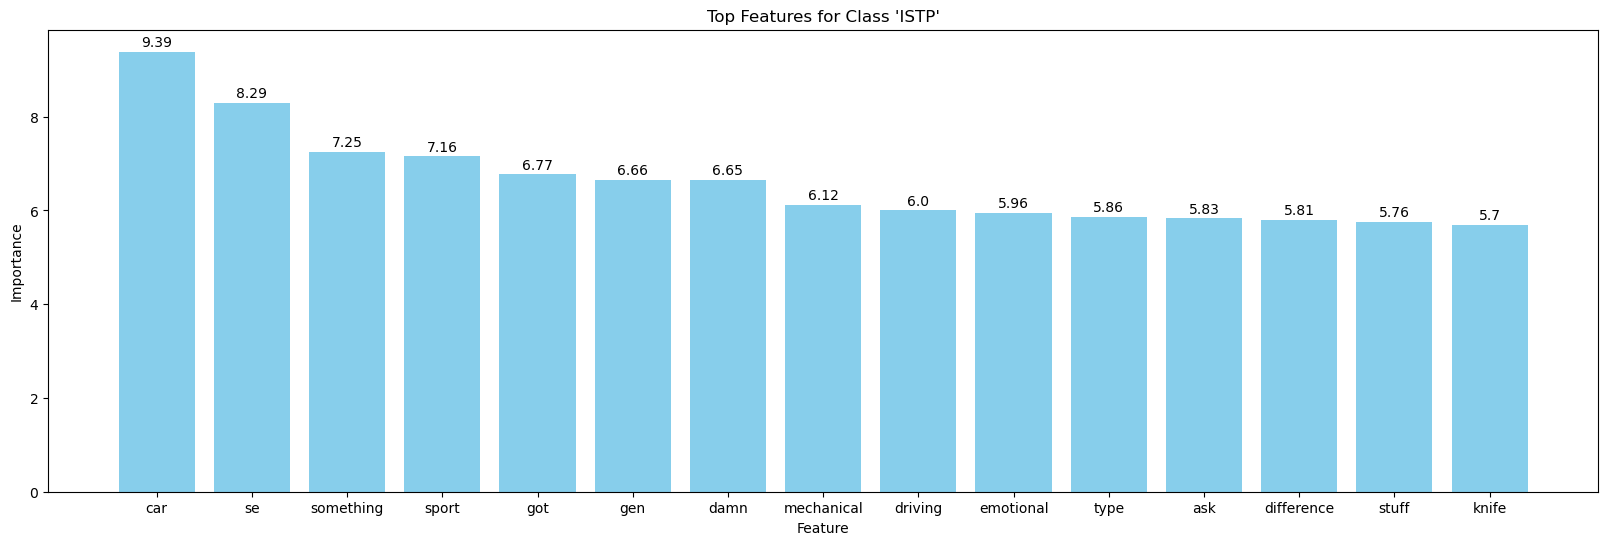

In [19]:
nltk.download('words')
english_words = set(nltk.corpus.words.words())

# only present english sentiment words
def is_english_word(word):
    return word.isalpha() and word.lower() in english_words

feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_

for class_index in range(coefficients.shape[0]):
    class_coeffs = coefficients[class_index]
    sorted_indices = class_coeffs.argsort()[::-1]
    class_name = map_label[class_index]
    
    # Exclude label-specific features and filter non-English or meaningless words
    filtered_features = [(feature_names[i], class_coeffs[i]) for i in sorted_indices
                         if class_name.lower() not in feature_names[i].lower() and is_english_word(feature_names[i])]

    # Select the top 15 meaningful English words
    top_features = filtered_features[:15]
    features, importances = zip(*top_features)

    # Plotting
    plt.figure(figsize=(20, 6))
    bars = plt.bar(features, importances, color='skyblue')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f"Top Features for Class '{class_name}'")
    plt.show()

## 4.4: restore all feature importance for each label

In [20]:
for class_index in range(coefficients.shape[0]):
    class_coeffs = coefficients[class_index]
    sorted_indices = class_coeffs.argsort()[::-1]
    class_name = map_label[class_index]
    
    # Extract all features for this class
    all_features = [(feature_names[i], class_coeffs[i]) for i in sorted_indices]

    # Create DataFrame and save to CSV
    df = pd.DataFrame(all_features, columns=['Feature', 'Importance'])
    df.to_csv(f'output/all_features_for_{class_name}.csv', index=False)

    print(f"All features for class {class_name} saved to 'output/all_features_for_{class_name}.csv'")

All features for class ENFJ saved to 'output/all_features_for_ENFJ.csv'
All features for class ENFP saved to 'output/all_features_for_ENFP.csv'
All features for class ENTJ saved to 'output/all_features_for_ENTJ.csv'
All features for class ENTP saved to 'output/all_features_for_ENTP.csv'
All features for class ESFJ saved to 'output/all_features_for_ESFJ.csv'
All features for class ESFP saved to 'output/all_features_for_ESFP.csv'
All features for class ESTJ saved to 'output/all_features_for_ESTJ.csv'
All features for class ESTP saved to 'output/all_features_for_ESTP.csv'
All features for class INFJ saved to 'output/all_features_for_INFJ.csv'
All features for class INFP saved to 'output/all_features_for_INFP.csv'
All features for class INTJ saved to 'output/all_features_for_INTJ.csv'
All features for class INTP saved to 'output/all_features_for_INTP.csv'
All features for class ISFJ saved to 'output/all_features_for_ISFJ.csv'
All features for class ISFP saved to 'output/all_features_for_IS